# PREDICTION TASK

The objective of this notebook is to show to use the different prediction models in order to reach a final prediction at the healthcare provider level.

## Benchmark models

The objective of these models is to show how dummy models perform. The end goal of the prediction task is to beat these dummy models. As usual, we first start by importing the required libraries.

In [174]:
from models.prediction_benchmarks import TimeGrowth, ARModel
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

We load the preprocessed file to begin with.

In [175]:
df = pd.read_csv('processed_data.csv')

The first model is called "time growth". The reason is that it uses the service year and quarter as features to predict the total claims. That is, it literally uses time features. We use a linear regression to train this model.

In [176]:
tg_model = TimeGrowth(df)
y_pred_tg, y_test_tg = tg_model.fit_predict()

We will use the R2, RMSE, MAE, and MAPE to evaluate our predictions. Given that a lot of the true values are zero, the MAPE of sklearn will yield infinite values. To solve that, we define our function of MAPE that adds a constant value to both the numerator and denominator of the ratio used to calculate the percentage error. The constant value chosen is the mean of total claims.

In [177]:
claims_mean = df['total_claims'].mean()

def mean_absolute_percentage_error(y_true, y_pred, epsilon=claims_mean):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs((y_true - y_pred) + epsilon) / (y_true + epsilon))) * 100

In addition, we define a function to calculate and print the evaluation metrics.

In [178]:
def calculate_and_print_metrics(y_pred, y_test, suffix):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"R² {suffix}: {r2:.4f}")
    print(f"RMSE {suffix}: {rmse:.2f}")
    print(f"MAE {suffix}: {mae:.2f}")
    print(f"MAPE {suffix}: {mape:.2f}%")

In [179]:
calculate_and_print_metrics(y_pred_tg, y_test_tg, "TG")

R² TG: 0.9326
RMSE TG: 88.40
MAE TG: 21.70
MAPE TG: 73.27%


Luckily or unluckily, this simple model performs really well. It will be hard to beat this model!

Next, we present a simple autoregressive model. Given that some providers only have 1 year (4 quarters) of data, we only use 2 lags of total claims as features. We cannot use 3 because, as in the time growth model, the last observation of each healthcare provider is left out to act as a test set.

In [180]:
ar_model = ARModel(df)
y_pred_ar, y_test_ar = ar_model.fit_predict()

calculate_and_print_metrics(y_pred_ar, y_test_ar, "AR")

R² AR: -1.2718
RMSE AR: 513.08
MAE AR: 36.08
MAPE AR: 80.58%


Some metrics of the autoregressive model are fine, but the negative R2 score cannot be ignored. This benchmark is easier to beat.

## Elastic net models

The dataset received has a lot of features, so regularization is definetily needed. That's why we choose Elastic Net as our next model. Since it has both L1 and L2 regularization, it can directly perform feature selection and coefficients shrinkage. Moreover, several of the features are correlated or part of a larger total, so L2 regularization must be used to control those effects.

Given that the time growth model has shown interesting results, we use its predictions as an extra feature. 

As seen before, it seems like 2 lags is not enough. Therefore, this time we use 4 lags in the case of claim features and 1 lag for any other features. Since we are working with time series data, only lagged variables are used as features. 

As usual, the first step is to import the required libraries.

In [181]:
from models.elastic_net import ElasticNetReg

In [182]:
en_reg = ElasticNetReg(df)
en_reg.prepare_data()
en_reg.fit_model()
y_pred_en_reg, y_test_en_reg = en_reg.get_predictions()

calculate_and_print_metrics(y_pred_en_reg, y_test_en_reg, "EN REG")

R² EN REG: 0.9642
RMSE EN REG: 66.51
MAE EN REG: 21.87
MAPE EN REG: 67.39%


There is a small improvement with respect to time growth model. Even though the MAE is rather low, the MAPE is high and stakeholders might not be too happy about it. We argue that one the reasons for the disconnect between the MAE and MAPE is the large range of total claims. The minimum is 0 and the maximum is above 20k. Therefore, small mistakes in the lower range of total claims highly penalize the MAPE.

In [183]:
min_claims = df.total_claims.min()
max_claims = df.total_claims.max()

print(f'Minimum number of total claims: {min_claims}')
print(f'Maximum number of total claims: {max_claims}')

Minimum number of total claims: 0
Maximum number of total claims: 20556


We believe that metrics are not everything when evaluating the performance of a model, interpretability matters too. We will check if the most important features of the model are intuitive. 

We observe that the 2 most important features are the first lags of total claims and stantard claims, on third place comes the prediction of the time growth model.

This is intuitive, it makes sense that the first lag of the target is an important feature. In addition, the fact that the prediction of the time growth model is important indicates that the sort of ensembling we are doing is working.

In [184]:
coef_en_reg = en_reg.get_ordered_features()
coef_en_reg.head(10)

,Feature,Coefficient
8,total_claims_lag_1,0.333203
0,standard_services_claims_lag_1,0.278524
87,y_pred_tg,0.216173
4,tele_services_claims_lag_1,0.084463
54,tele_services_psychotherapy_patients_lag_1,0.054348
51,tele_services_patients_lag_1,0.053799
20,total_psychotherapy_claims_lag_1,0.036945
55,total_psychotherapy_patients_lag_1,0.028326
52,total_patients_lag_1,0.022341
6,tele_services_claims_lag_3,-0.013987


At this point, we ask ourselves about the usefulness of our model. Now in 2024 we know how 2021 was, but back in 2020 in the middle of the COVID-19 pandemic, how 2021 was going to be was rather uncertain. There was a possibility that it all returned to how things were back in 2018/19.

Since we are using the last observation of each npi as test set, the model is biased to fit the parameters towards what was happening in that last observation.

In finance, every investment strategy has to go to a process that is called backtesting. Backtesting is usually done using historical data. There are certain periods in the financial markets that are of particual interest to investors. For instance, the Great Financial Crisis (GFC) of 2008. It is of interest to leearn how a model would behave in market conditions similar to those of the GFC. Therefore, even if a model is trained using data from 2010 to 2015, it is common to test it with data of 2008. From a historical point of view, that is incorrect because the model is using data that was not available in 2008. However, the objective of the backtesting is not historical accuracy, but to stress test the investment strategy (which is ignorant of 2008) with 2008 conditions.

We believe we can use the idea of backtesting in our demand prediction task as well. Since we don't have too much historical data and the available historical data is not uniform at the provider level, we cannot use a time series split, which would be ideal. The closest approximation is to use a regular train test split with shuffling. Since each row in the dataset has only lagged features, there is no data leakage at the row level. By doing this kind of split we believe that the model will be more robust and more reliable to predict on unseen data. With this kind of split 2020 observations might end up in the training set while 2018 observations end up in the test set. We consider that is fine because 2021 could have ended up being a back to business as usual scenario.

We import a new elastic net model that uses this kind of data preprocessing.

In [185]:
from models.elastic_net import ElasticNetNew

The metrics using this new approach are slightly better than those found using the traditional approach to time series.

In [186]:
en_new = ElasticNetNew(df)
en_new.prepare_data()
en_new.fit_model()
y_pred_en_new, y_test_en_new = en_new.get_predictions()

calculate_and_print_metrics(y_pred_en_new, y_test_en_new, "EN NEW")

R² EN NEW: 0.9720
RMSE EN NEW: 54.86
MAE EN NEW: 18.06
MAPE EN NEW: 66.82%


In addition, we observe that the most important features are quite similar to those found when using the traditional approach.

Surprisingly, the coefficient of the first lag of the tele services claims is almost 2x the previous model. Even though the tele service claims increase only during 2020, this new approach assings a higher importance to it.

In [187]:
coef_en_new = en_new.get_ordered_features()
coef_en_new.head(10)

,Feature,Coefficient
8,total_claims_lag_1,0.282104
0,standard_services_claims_lag_1,0.250089
87,y_pred_tg,0.191916
4,tele_services_claims_lag_1,0.152327
20,total_psychotherapy_claims_lag_1,0.075614
54,tele_services_psychotherapy_patients_lag_1,0.062800
21,total_psychotherapy_claims_lag_2,-0.062148
55,total_psychotherapy_patients_lag_1,0.050864
12,standard_services_psychotherapy_claims_lag_1,0.044373
52,total_patients_lag_1,0.042692


## Boosting models

The elastic net models used before can only capture linear relations. As a final refinement, we want to use a model that can capture non-linear relations. To do so, we use a boosting that is based on regression trees. Just like before, we will use the prediction of the elastic net model as an extra feature.

In addition, elastic net is a model with high bias and low variance because it is based on linear regression. It has been shown that booster models are capable of decreasing the bias of models, so we believe it is a good complement to the elastic net.

First, we import the required libraries.

In [188]:
from models.booster import BoosterReg

The metrics of the booster model do not improve with respecto to the elastic net. Nonetheless, we don't feel this is a bad thing. The metrics are rather similar and we consider that the booster model is likely to generalize well because we have tuned several hyperparameters to ensure that overfitting is controlled.

In [189]:
boost_reg = BoosterReg(df)
boost_reg.prepare_data()
boost_reg.fit_model()
y_pred_boost_reg, y_test_boost_reg = boost_reg.get_predictions()

calculate_and_print_metrics(y_pred_boost_reg, y_test_boost_reg, "BOOST REG")

R² BOOST REG: 0.9322
RMSE BOOST REG: 91.54
MAE BOOST REG: 24.30
MAPE BOOST REG: 68.61%


When it comes to the importance of features, these are somehow similar to those found in the elastic net model. One thing that we were not expecting was that the elastic net prediction was not too important. This might indicate that the booster model is finding patterns beyond those of the elastic net, which was the ultimate goal of using this non-linear model.

In [190]:
coef_boost_reg = boost_reg.get_sorted_importances()
coef_boost_reg.head(10)

,Feature,Importance
8,total_claims_lag_1,0.224401
1,standard_services_claims_lag_2,0.193162
2,standard_services_claims_lag_3,0.088853
20,total_psychotherapy_claims_lag_1,0.068245
36,total_other_payers_claims_lag_1,0.055646
51,tele_services_patients_lag_1,0.041235
11,total_claims_lag_4,0.037727
3,standard_services_claims_lag_4,0.036341
60,broadband_access_lag_1,0.036329
87,y_pred_en_reg,0.035560


Just like we did in the elastic net case, we also consider the "backtesting" approach to the booster model. As a reminder, we apply the classic train test split with the hope of increasing the generalization power of the model. One of the advantages of following this approach is that we can set the booster model to apply subsampling to the input data to further control for overfitting.

As usual, we import the required libraries first.

In [191]:
from models.booster import BoosterNew

The metrics don't show an improvement with respect to the elastic net results. Just like before, we don't mind about it because more controls have been set to decrease any possible overfitting, so we believe that the boosting model is more powerful and more likely to generalize well.

In [192]:
boost_new = BoosterNew(df)
boost_new.prepare_data()
boost_new.fit_model()
y_pred_boost_new, y_test_boost_new = boost_new.get_predictions()

calculate_and_print_metrics(y_pred_boost_new, y_test_boost_new, "BOOST NEW")

R² BOOST NEW: 0.9720
RMSE BOOST NEW: 53.60
MAE BOOST NEW: 19.38
MAPE BOOST NEW: 62.87%


Once again, the prediction of the elastic net model is not too important for the boosting model. In general, the importance of the features has changed when compared to the elastic net model, but not too dramatically.

Something that we see for the first time is that our created features appear among the most important features. This shows that aggregation variables and ratios of claims per patient are important in the boosting model.

In [193]:
coef_boost_new = boost_new.get_sorted_importances()
coef_boost_new.head(10)

,Feature,Importance
9,total_claims_lag_2,0.231058
8,total_claims_lag_1,0.199858
70,total_patients_county_lag_1,0.133022
58,psychotherapy_provider_through_taxonomy_lag_1,0.078407
14,standard_services_psychotherapy_claims_lag_3,0.047542
87,y_pred_en_new,0.043868
20,total_psychotherapy_claims_lag_1,0.035360
60,broadband_access_lag_1,0.032512
36,total_other_payers_claims_lag_1,0.030324
3,standard_services_claims_lag_4,0.014548


# MERGING PREDICTION WITH CLUSTERING

The final task of this project is to include the finding of the clustering model in the prediction. There are several ways to do so, we first start with adding the cluster as an extra feature to see if its among the most important features or if the order of features is changed.

## Adding clusters as a feature

First, we need to merge the cluster datasat with our current dataset.

In [194]:
clustered_df = pd.read_csv('clustered_dataset.csv')
df = df.merge(clustered_df[['npi', 'cluster']], on='npi', how='left')

There is a small improvement with respect to the previous boosting model, specially in the MAPE, which has proved to be hard to decrease.

In [195]:
boost_reg_c = BoosterReg(df)
boost_reg_c.prepare_data()
boost_reg_c.fit_model()
y_pred_boost_reg_c, y_test_boost_reg_c = boost_reg_c.get_predictions()

calculate_and_print_metrics(y_pred_boost_reg_c, y_test_boost_reg_c, "BOOST REG C")

R² BOOST REG C: 0.9454
RMSE BOOST REG C: 86.78
MAE BOOST REG C: 25.59
MAPE BOOST REG C: 64.29%


The cluster feature is not among the most important. However, it has altered the order of important features. This means that the interaction of clusters with other features is meaningful.

In [196]:
coef_boost_reg_c = boost_reg_c.get_sorted_importances()
coef_boost_reg_c.head(10)

,Feature,Importance
1,standard_services_claims_lag_2,0.289149
8,total_claims_lag_1,0.200922
3,standard_services_claims_lag_4,0.058513
13,standard_services_psychotherapy_claims_lag_2,0.053749
36,total_other_payers_claims_lag_1,0.049866
51,tele_services_patients_lag_1,0.043392
50,standard_services_patients_lag_1,0.042297
88,y_pred_en_reg,0.035070
75,claims_per_patient_lag_1,0.028721
9,total_claims_lag_2,0.028236


When using the regular train test split, we observe that the metrics do not improve. For this version of the model, adding cluster as a feature does not lead to a change.

In [197]:
boost_new_c = BoosterNew(df)
boost_new_c.prepare_data()
boost_new_c.fit_model()
y_pred_boost_new_c, y_test_boost_new_c = boost_new_c.get_predictions()

calculate_and_print_metrics(y_pred_boost_new_c, y_test_boost_new_c, "BOOST NEW C")

R² BOOST NEW C: 0.9687
RMSE BOOST NEW C: 60.25
MAE BOOST NEW C: 20.70
MAPE BOOST NEW C: 61.55%


The irrelevance of clusters as a feature can be further observed in the importance of features, which reamins unchanged.

In [198]:
coef_boost_new_c = boost_new_c.get_sorted_importances()
coef_boost_new_c.head(10)

,Feature,Importance
20,total_psychotherapy_claims_lag_1,0.276415
8,total_claims_lag_1,0.132445
3,standard_services_claims_lag_4,0.108007
36,total_other_payers_claims_lag_1,0.076655
9,total_claims_lag_2,0.064341
10,total_claims_lag_3,0.052772
23,total_psychotherapy_claims_lag_4,0.037903
73,patients_quarter_lag_1,0.025004
50,standard_services_patients_lag_1,0.023453
75,claims_per_patient_lag_1,0.019891


## A model per cluster

Another option to include the information of clusters is to fit a model per cluster, to take advantage of the intrinsic differences among clusters.

We believe there are enough observations in each cluster to run a model for each of them.

In [199]:
cluster_counts = df['cluster'].value_counts()

print("Number of rows for each cluster value:")
print(cluster_counts)

Number of rows for each cluster value:
cluster
1.0    34488
0.0    26932
2.0    11424
Name: count, dtype: int64


We see that the metrics are quite different among different clusters. Thus, it seems reasonable to build a different model per cluster.

In [200]:
# Initialize a dictionary to store results and models for each cluster
results_reg = {}
models_reg = {}

# Loop through each cluster
for cluster in range(0, 3):
    print(f"Running model for cluster {cluster}")
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['cluster'] == cluster]

    # Create and run the BoosterReg model for the current cluster
    model_name = f"booster_reg_model_cluster_{cluster}"
    models_reg[model_name] = BoosterReg(cluster_df)
    models_reg[model_name].prepare_data()
    models_reg[model_name].fit_model()
    
    y_pred, y_test = models_reg[model_name].get_predictions()
    predictions_df = models_reg[model_name].create_predictions_dataframe()
    sorted_importances_df = models_reg[model_name].get_sorted_importances()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store the results
    results_reg[cluster] = {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'predictions_df': predictions_df,
        'sorted_importances_df': sorted_importances_df
    }

    # Print the results for the current cluster
    print(f"Cluster {cluster} Results - Booster Reg:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print('=============================')

Running model for cluster 0
Cluster 0 Results - Booster Reg:
R²: 0.7545
RMSE: 108.94
MAE: 20.85
MAPE: 65.84%
Running model for cluster 1
Cluster 1 Results - Booster Reg:
R²: 0.9567
RMSE: 102.12
MAE: 32.07
MAPE: 55.49%
Running model for cluster 2
Cluster 2 Results - Booster Reg:
R²: 0.9307
RMSE: 15.64
MAE: 5.20
MAPE: 91.65%


For cluster 0, it seems like standard psychotherapy claims is the most important driver.

In [201]:
results_reg[0]['sorted_importances_df'].head(10)

,Feature,Importance
14,standard_services_psychotherapy_claims_lag_3,0.654178
22,total_psychotherapy_claims_lag_3,0.098819
0,standard_services_claims_lag_1,0.056128
8,total_claims_lag_1,0.046879
4,tele_services_claims_lag_1,0.025616
88,y_pred_en_reg,0.022057
9,total_claims_lag_2,0.020725
10,total_claims_lag_3,0.015956
23,total_psychotherapy_claims_lag_4,0.013070
50,standard_services_patients_lag_1,0.006012


For cluster 1, similar features to those found in the original prediction model without clusters.

In [202]:
results_reg[1]['sorted_importances_df'].head(10)

,Feature,Importance
8,total_claims_lag_1,0.334496
1,standard_services_claims_lag_2,0.121476
20,total_psychotherapy_claims_lag_1,0.108205
9,total_claims_lag_2,0.091051
52,total_patients_lag_1,0.055387
51,tele_services_patients_lag_1,0.045837
88,y_pred_en_reg,0.024731
73,patients_quarter_lag_1,0.024291
5,tele_services_claims_lag_2,0.023531
50,standard_services_patients_lag_1,0.023468


For cluster 2, the most important feature is the prediction of the elastic net model, which could indicate that not too many non-linear relations were found. Other than that, there is a mix of standard and total claims and patients.

In [203]:
results_reg[2]['sorted_importances_df'].head(10)

,Feature,Importance
88,y_pred_en_reg,0.284319
0,standard_services_claims_lag_1,0.279046
8,total_claims_lag_1,0.184731
52,total_patients_lag_1,0.091746
50,standard_services_patients_lag_1,0.077008
36,total_other_payers_claims_lag_1,0.023466
41,onehot__provider_size_Small_lag_1,0.012259
3,standard_services_claims_lag_4,0.011563
51,tele_services_patients_lag_1,0.007091
13,standard_services_psychotherapy_claims_lag_2,0.006286


Moving to the second approach of treating time series, the metrics are quite different among clusters as well. Moreover, if we rank them by MAE, the cluster metrics follow a similar distribution to the one found using the convetional approach of trating time series.

In [204]:
# Initialize dictionaries to store results and models for each cluster
results_new = {}
models_new = {}

# Loop through each cluster
for cluster in range(0, 3):
    print(f"Running model for cluster {cluster}")
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['cluster'] == cluster]

    # Create and run the BoosterNew model for the current cluster
    model_name = f"booster_new_model_cluster_{cluster}"
    models_new[model_name] = BoosterNew(cluster_df)
    models_new[model_name].prepare_data()
    models_new[model_name].fit_model()
    
    y_pred, y_test = models_new[model_name].get_predictions()
    predictions_df = models_new[model_name].create_predictions_dataframe()
    sorted_importances_df = models_new[model_name].get_sorted_importances()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store the results
    results_new[cluster] = {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'predictions_df': predictions_df,
        'sorted_importances_df': sorted_importances_df
    }

    # Print the results for the current cluster
    print(f"Cluster {cluster} Results - Booster New:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print('=============================')


Running model for cluster 0


Cluster 0 Results - Booster New:
R²: 0.9696
RMSE: 40.07
MAE: 14.16
MAPE: 63.88%
Running model for cluster 1
Cluster 1 Results - Booster New:
R²: 0.9716
RMSE: 69.43
MAE: 23.52
MAPE: 55.70%
Running model for cluster 2
Cluster 2 Results - Booster New:
R²: 0.8897
RMSE: 19.59
MAE: 7.64
MAPE: 84.59%


For cluster 0, unlike before, only one psychotherapy feature is among the most important ones. A couple of aggregated variables appear.

In [205]:
results_new[0]['sorted_importances_df'].head(10)

,Feature,Importance
8,total_claims_lag_1,0.312647
15,standard_services_psychotherapy_claims_lag_4,0.201037
0,standard_services_claims_lag_1,0.123103
10,total_claims_lag_3,0.102788
1,standard_services_claims_lag_2,0.032050
69,npi_county_lag_1,0.023631
76,tele_claims_per_patient_lag_1,0.019623
9,total_claims_lag_2,0.019486
50,standard_services_patients_lag_1,0.014764
72,claims_quarter_lag_1,0.014267


For cluster 1, some of the same features as those found when predicting without clusters appear, but in different order.

In [206]:
results_new[1]['sorted_importances_df'].head(10)

,Feature,Importance
2,standard_services_claims_lag_3,0.227910
8,total_claims_lag_1,0.196665
55,total_psychotherapy_patients_lag_1,0.133236
9,total_claims_lag_2,0.069541
36,total_other_payers_claims_lag_1,0.063654
52,total_patients_lag_1,0.056757
20,total_psychotherapy_claims_lag_1,0.047737
54,tele_services_psychotherapy_patients_lag_1,0.029128
3,standard_services_claims_lag_4,0.016278
75,claims_per_patient_lag_1,0.014290


For cluster 2, total and standard claims and patients drive the most important features.

In [207]:
results_new[2]['sorted_importances_df'].head(10)

,Feature,Importance
8,total_claims_lag_1,0.229830
0,standard_services_claims_lag_1,0.143995
9,total_claims_lag_2,0.095827
52,total_patients_lag_1,0.050145
3,standard_services_claims_lag_4,0.048613
50,standard_services_patients_lag_1,0.035919
11,total_claims_lag_4,0.027666
80,standard_claims_per_patient_by_county_lag_1,0.026287
81,claims_per_patient_by_grouping_lag_1,0.023883
13,standard_services_psychotherapy_claims_lag_2,0.023498


Overall, we see that the drives within each cluster vary. More interestingly to us, the drivers vary when the treatment of time series change. Therefore, it would make sense to combine both of the predictions to reach a final one. To put it in simple terms, the predictions of both approaches show low correlation, so there is a potentially high gain of combining them. The final combined predictions are more likely to generalize well.

# FINAL PREDICTIONS PER HEALTHCARE PROVIDER

Before creating the final set of predictions, we need to make adjustments to the dataset used. We will generate predictions only for the providers that have data in 2020 because we are required to create predictions for the first quarter of 2021.

In [208]:
npi_with_2020_data = df[df['service_year'] == 2020]['npi'].unique()
filtered_df = df[df['npi'].isin(npi_with_2020_data)]

print(f"Original DataFrame shape: {df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")

Original DataFrame shape: (85436, 63)
Filtered DataFrame shape: (72844, 63)


We add an extra row per each provider, this row is a "dummy" row representing the first quarter of 2021. We do that to align the dataframe with the logic of the booster to create lagged features. We want the data of the last quarter of 2020 to be the first lag.

In [209]:
# Get unique npis
unique_npi = filtered_df['npi'].unique()

# Create new rows DataFrame with unique npis
new_rows = pd.DataFrame(unique_npi, columns=['npi'])

# Set service_year and service_quarter columns
new_rows['service_year'] = 2021
new_rows['service_quarter'] = 1

# Map clusters from the original DataFrame to the new DataFrame
npi_cluster_map = filtered_df.set_index('npi')['cluster'].to_dict()
new_rows['cluster'] = new_rows['npi'].map(npi_cluster_map)

# Add other columns with 0 values (excluding 'cluster')
other_columns = filtered_df.columns.difference(['npi', 'service_year', 'service_quarter', 'cluster'])
for col in other_columns:
    new_rows[col] = 0

# Concatenate the new rows with the original filtered_df
extended_df = pd.concat([filtered_df, new_rows], ignore_index=True)

# Sort the DataFrame by npi, service_year, and service_quarter
extended_df = extended_df.sort_values(by=['npi', 'service_year', 'service_quarter'])

# Print the shape of the extended DataFrame to verify the result
print(f"Original filtered DataFrame shape: {filtered_df.shape}")
print(f"Extended DataFrame shape: {extended_df.shape}")

Original filtered DataFrame shape: (72844, 63)
Extended DataFrame shape: (81764, 63)


Now, since we only want one prediction per provider, we drop all the data before 2020.

In [210]:
extended_df = extended_df[extended_df['service_year'].isin([2020, 2021])]
print(f"Extended DataFrame shape: {extended_df.shape}")

Extended DataFrame shape: (44600, 63)


Then, we split the dataset into 3 smaller ones to get one subset per cluster.

In [211]:
# Create three separate DataFrames for each cluster value
df_cluster_0 = extended_df[extended_df['cluster'] == 0].reset_index(drop=True)
df_cluster_1 = extended_df[extended_df['cluster'] == 1].reset_index(drop=True)
df_cluster_2 = extended_df[extended_df['cluster'] == 2].reset_index(drop=True)

# Print the number of rows in each DataFrame to verify
print(f"Number of rows in cluster 0 DataFrame: {len(df_cluster_0)}")
print(f"Number of rows in cluster 1 DataFrame: {len(df_cluster_1)}")
print(f"Number of rows in cluster 2 DataFrame: {len(df_cluster_2)}")

Number of rows in cluster 0 DataFrame: 16695
Number of rows in cluster 1 DataFrame: 20060
Number of rows in cluster 2 DataFrame: 7845


Now that the datasets have been created, we need to create predictions for each of them. Since we are using a stacked ensemble, we first need to add the required predictions of the base models before passing them to the next one.

Therefore, we first create the time growth prediction for each dataset.

In [212]:
tg_pred = tg_model.predict_for_period(2021, 1)

Now, we merge the predictions with each of the datasets.

In [213]:
# Merge the 'y_pred_tg' column into each cluster DataFrame
df_cluster_0 = df_cluster_0.merge(tg_pred[['npi', 'y_pred_tg']], on='npi', how='left')
df_cluster_1 = df_cluster_1.merge(tg_pred[['npi', 'y_pred_tg']], on='npi', how='left')
df_cluster_2 = df_cluster_2.merge(tg_pred[['npi', 'y_pred_tg']], on='npi', how='left')

We have to create elastic net models per cluster as well because we need their predictions as well.

In [214]:
# Initialize dictionaries to store rmodels for each cluster
models_en_reg = {}

# Loop through each cluster
for cluster in range(0, 3):
    print(f"Running model for cluster {cluster}")
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['cluster'] == cluster]

    # Create and run the BoosterNew model for the current cluster
    model_name = f"en_reg_cluster_{cluster}"
    models_en_reg[model_name] = ElasticNetReg(cluster_df)
    models_en_reg[model_name].prepare_data()
    models_en_reg[model_name].fit_model()

print('Done!')

Running model for cluster 0
Running model for cluster 1
Running model for cluster 2
Done!


In [215]:
# Initialize dictionaries to store rmodels for each cluster
models_en_new = {}

# Loop through each cluster
for cluster in range(0, 3):
    print(f"Running model for cluster {cluster}")
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['cluster'] == cluster]

    # Create and run the BoosterNew model for the current cluster
    model_name = f"en_new_cluster_{cluster}"
    models_en_new[model_name] = ElasticNetNew(cluster_df)
    models_en_new[model_name].prepare_data()
    models_en_new[model_name].fit_model()

print('Done!')

Running model for cluster 0
Running model for cluster 1
Running model for cluster 2
Done!


We define a function to ensure the data has the same expected columns.

In [216]:
def process_new_data(new_data, column_to_ignore):
    # Function to create lagged features for a single column
    def create_lagged_features(df, column, lags):
        for lag in lags:
            lagged_col_name = f'{column}_lag_{lag}'
            df[lagged_col_name] = df.groupby('npi')[column].shift(lag)
        return df
    
    # Keep the original dataframe unchanged
    new_data = new_data.copy()

    # Create lagged features for the new data
    claims_columns = [col for col in new_data.columns if col.endswith("claims")]
    other_columns = [col for col in new_data.columns if col not in claims_columns and col != column_to_ignore]

    for col in claims_columns:
        new_data = create_lagged_features(new_data, col, lags=[1, 2, 3, 4])

    for col in other_columns:
        new_data = create_lagged_features(new_data, col, lags=[1])

    new_data = new_data.dropna()

    return new_data


In [217]:
def reorder_and_filter_columns(df, column_order):
    common_columns = [col for col in column_order if col in df.columns]
    return df[common_columns].copy()

In [218]:
en_reg_0 = models_en_reg['en_reg_cluster_0']
en_reg_1 = models_en_reg['en_reg_cluster_1']
en_reg_2 = models_en_reg['en_reg_cluster_2']

df_cluster_0_en = process_new_data(df_cluster_0, 'y_pred_tg')
df_cluster_1_en = process_new_data(df_cluster_1, 'y_pred_tg')
df_cluster_2_en = process_new_data(df_cluster_2, 'y_pred_tg')

en_feats_order = en_reg_0.get_expected_feature_order()

# Reorder and filter columns for each DataFrame
df_cluster_0_en = reorder_and_filter_columns(df_cluster_0_en, en_feats_order)
df_cluster_1_en = reorder_and_filter_columns(df_cluster_1_en, en_feats_order)
df_cluster_2_en = reorder_and_filter_columns(df_cluster_2_en, en_feats_order)

We get the elastic net predictions for each cluster and model.

In [219]:
pred_en_reg_0 = en_reg_0.predict_on_new_data(df_cluster_0_en)
pred_en_reg_1 = en_reg_1.predict_on_new_data(df_cluster_1_en)
pred_en_reg_2 = en_reg_2.predict_on_new_data(df_cluster_2_en)

In [220]:
en_new_0 = models_en_new['en_new_cluster_0']
en_new_1 = models_en_new['en_new_cluster_1']
en_new_2 = models_en_new['en_new_cluster_2']

pred_en_new_0 = en_new_0.predict_on_new_data(df_cluster_0_en)
pred_en_new_1 = en_new_1.predict_on_new_data(df_cluster_1_en)
pred_en_new_2 = en_new_2.predict_on_new_data(df_cluster_2_en)

In [221]:
def repeat_values(pred_array, repeat_times=5):
    return np.repeat(pred_array, repeat_times)

pred_en_reg_0 = repeat_values(pred_en_reg_0, 5)
pred_en_reg_1 = repeat_values(pred_en_reg_1, 5)
pred_en_reg_2 = repeat_values(pred_en_reg_2, 5)

We need to drop the time growth prediction and add the elastic net predictions.

In [222]:
df_cluster_0_reg = df_cluster_0.drop(columns=['y_pred_tg'], errors='ignore')
df_cluster_0_reg['y_pred_en_reg'] = pred_en_reg_0

df_cluster_1_reg = df_cluster_1.drop(columns=['y_pred_tg'], errors='ignore')
df_cluster_1_reg['y_pred_en_reg'] = pred_en_reg_1

df_cluster_2_reg = df_cluster_2.drop(columns=['y_pred_tg'], errors='ignore')
df_cluster_2_reg['y_pred_en_reg'] = pred_en_reg_2

In [223]:
pred_en_new_0 = repeat_values(pred_en_new_0, 5)
pred_en_new_1 = repeat_values(pred_en_new_1, 5)
pred_en_new_2 = repeat_values(pred_en_new_2, 5)

In [224]:
df_cluster_0_new = df_cluster_0.drop(columns=['y_pred_tg'], errors='ignore')
df_cluster_0_new['y_pred_en_new'] = pred_en_new_0

df_cluster_1_new = df_cluster_1.drop(columns=['y_pred_tg'], errors='ignore')
df_cluster_1_new['y_pred_en_new'] = pred_en_new_1

df_cluster_2_new = df_cluster_2.drop(columns=['y_pred_tg'], errors='ignore')
df_cluster_2_new['y_pred_en_new'] = pred_en_new_2

In [225]:
boost_reg_0 = models_reg['booster_reg_model_cluster_0']
boost_reg_1 = models_reg['booster_reg_model_cluster_1']
boost_reg_2 = models_reg['booster_reg_model_cluster_2']

df_cluster_0_reg = process_new_data(df_cluster_0_reg, 'y_pred_en_reg')
df_cluster_1_reg = process_new_data(df_cluster_1_reg, 'y_pred_en_reg')
df_cluster_2_reg = process_new_data(df_cluster_2_reg, 'y_pred_en_reg')

boost_reg_order = boost_reg_0.get_expected_feature_order()

df_cluster_0_reg = df_cluster_0_reg[boost_reg_order]
df_cluster_1_reg = df_cluster_1_reg[boost_reg_order]
df_cluster_2_reg = df_cluster_2_reg[boost_reg_order]

In [226]:
boost_new_0 = models_new['booster_new_model_cluster_0']
boost_new_1 = models_new['booster_new_model_cluster_1']
boost_new_2 = models_new['booster_new_model_cluster_2']

df_cluster_0_new = process_new_data(df_cluster_0_new, 'y_pred_en_new')
df_cluster_1_new = process_new_data(df_cluster_1_new, 'y_pred_en_new')
df_cluster_2_new = process_new_data(df_cluster_2_new, 'y_pred_en_new')

boost_new_order = boost_new_0.get_expected_feature_order()

df_cluster_0_new = df_cluster_0_new[boost_new_order]
df_cluster_1_new = df_cluster_1_new[boost_new_order]
df_cluster_2_new = df_cluster_2_new[boost_new_order]

We are ready to run the final models!

In [227]:
pred_boost_reg_0 = boost_reg_0.predict_on_new_data(df_cluster_0_reg)
pred_boost_reg_1 = boost_reg_1.predict_on_new_data(df_cluster_1_reg)
pred_boost_reg_2 = boost_reg_2.predict_on_new_data(df_cluster_2_reg)

In [228]:
pred_boost_new_0 = boost_new_0.predict_on_new_data(df_cluster_0_new)
pred_boost_new_1 = boost_new_1.predict_on_new_data(df_cluster_1_new)
pred_boost_new_2 = boost_new_2.predict_on_new_data(df_cluster_2_new)

For the final prediction, we combine both approaches.

In [231]:
weight_reg = 0.75
weight_new = 0.25

final_pred_0 = weight_reg * pred_boost_reg_0 + weight_new * pred_boost_new_0
final_pred_1 = weight_reg * pred_boost_reg_1 + weight_new * pred_boost_new_1
final_pred_2 = weight_reg * pred_boost_reg_2 + weight_new * pred_boost_new_2

In [239]:
final_pred_0 = np.round(final_pred_0, 0)
final_pred_1 = np.round(final_pred_1, 0)
final_pred_2 = np.round(final_pred_2, 0)

In [258]:
def replace_last_observation_with_predictions(df, predictions, id_column='npi', target_column='total_claims'):
    # Make a copy of the original DataFrame to avoid modifying it
    df = df.copy()
    
    # Ensure the predictions array length matches the number of unique identifiers
    unique_ids = df[id_column].unique()
    if len(predictions) != len(unique_ids):
        raise ValueError("Length of predictions array must match the number of unique identifiers.")
    
    # Create a dictionary to map each unique identifier to its corresponding prediction
    id_to_prediction = dict(zip(unique_ids, predictions))
    
    # Replace the last observation of target_column for each id_column with the corresponding prediction
    last_indices = df.groupby(id_column).tail(1).index
    for idx, npi in zip(last_indices, unique_ids):
        df.at[idx, target_column] = id_to_prediction[npi]
    
    return df

In [259]:
# Apply the function to each DataFrame
df_cluster_0_final = replace_last_observation_with_predictions(df_cluster_0, final_pred_0, id_column='npi', target_column='total_claims')
df_cluster_1_final = replace_last_observation_with_predictions(df_cluster_1, final_pred_1, id_column='npi', target_column='total_claims')
df_cluster_2_final = replace_last_observation_with_predictions(df_cluster_2, final_pred_2, id_column='npi', target_column='total_claims')

In [261]:
def impute_date_column(df, date_column='date', impute_value='2021-03-31'):
    df[date_column] = df[date_column].replace(0, impute_value)
    return df

In [262]:
df_cluster_0_final = impute_date_column(df_cluster_0_final)
df_cluster_1_final = impute_date_column(df_cluster_1_final)
df_cluster_2_final = impute_date_column(df_cluster_2_final)

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['image.cmap'] = 'plasma'
sns.set_palette("plasma")

In [267]:
def process_and_plot(df, title):
    # Convert 'date' column to datetime if not already
    df['date'] = pd.to_datetime(df['date'])

    # Sum total_claims per date
    df_sum = df.groupby('date')['total_claims'].sum().reset_index()

    # Define x-ticks
    x_ticks = pd.to_datetime(['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31'])

    # Plot the evolution of the sum
    plt.figure(figsize=(10, 6))
    plt.plot(df_sum['date'], df_sum['total_claims'], marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Total Claims')
    plt.grid(True)
    plt.xticks(x_ticks, x_ticks.strftime('%Y-%m-%d'))
    plt.show()

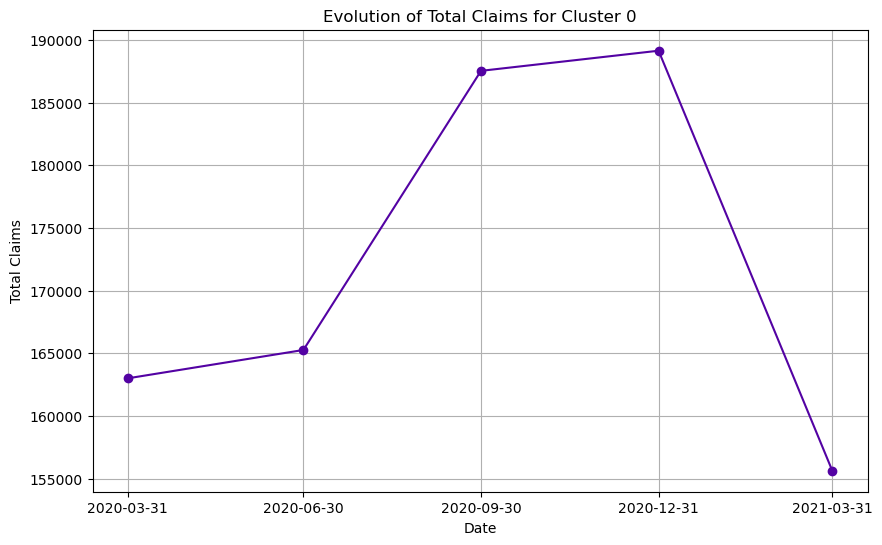

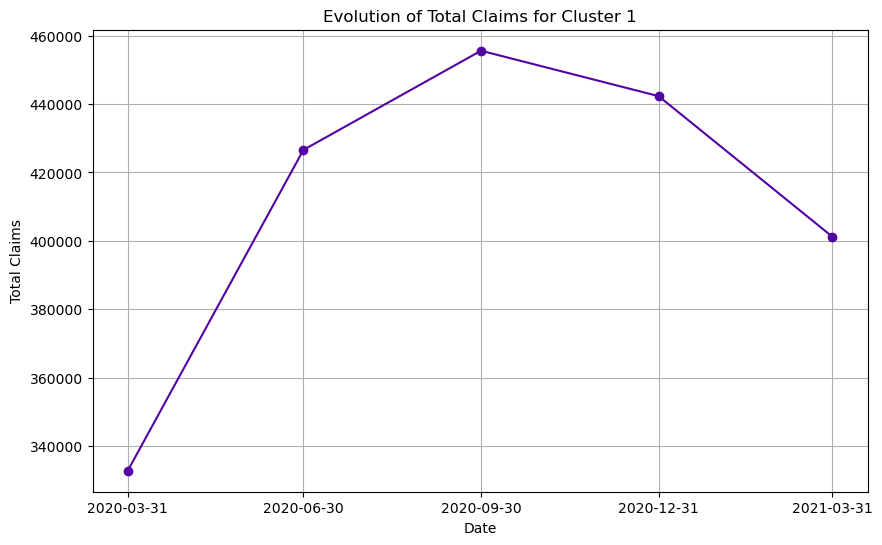

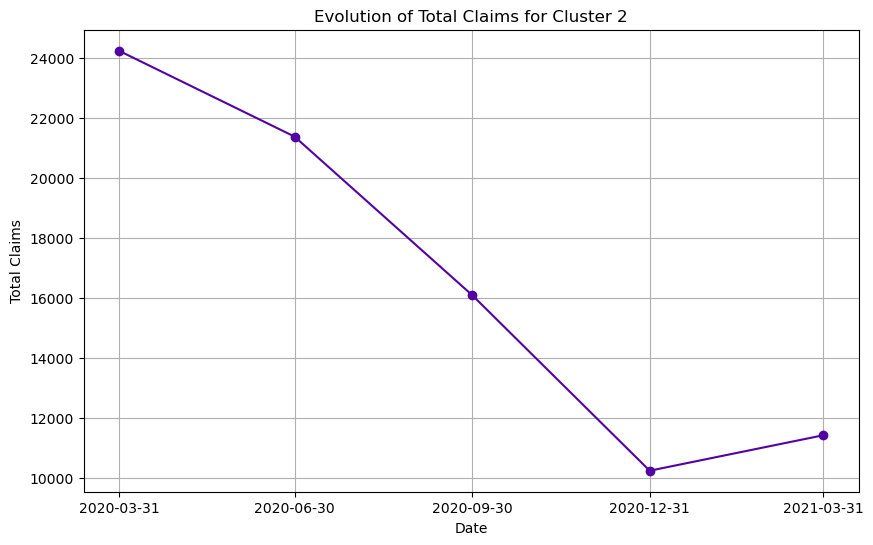

In [268]:
process_and_plot(df_cluster_0_final, 'Evolution of Total Claims for Cluster 0')
process_and_plot(df_cluster_1_final, 'Evolution of Total Claims for Cluster 1')
process_and_plot(df_cluster_2_final, 'Evolution of Total Claims for Cluster 2')

In [279]:
def calculate_growth_rates(df):
    # Convert 'date' column to datetime if not already
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Sum total_claims per date
    df_sum = df.groupby('date')['total_claims'].sum()

    # Extract total_claims for the specific dates
    total_claims_start_year = df_sum.get(pd.Timestamp('2020-03-31'), 0)
    total_claims_end_year = df_sum.get(pd.Timestamp('2021-03-31'), 0)
    total_claims_start_quarter = df_sum.get(pd.Timestamp('2020-12-31'), 0)
    total_claims_end_quarter = df_sum.get(pd.Timestamp('2021-03-31'), 0)

    # Calculate growth rates
    yearly_growth = (total_claims_end_year - total_claims_start_year) / total_claims_start_year if total_claims_start_year != 0 else float('inf')
    quarterly_growth = (total_claims_end_quarter - total_claims_start_quarter) / total_claims_start_quarter if total_claims_start_quarter != 0 else float('inf')

    return yearly_growth, quarterly_growth, total_claims_end_quarter

In [280]:
# Calculate growth rates for each DataFrame
yearly_growth_0, quarterly_growth_0, cluster_0_pred = calculate_growth_rates(df_cluster_0_final)
yearly_growth_1, quarterly_growth_1, cluster_1_pred = calculate_growth_rates(df_cluster_1_final)
yearly_growth_2, quarterly_growth_2, cluster_2_pred = calculate_growth_rates(df_cluster_2_final)

print("Cluster 0 - Yearly Growth: {:.2%}, Quarterly Growth: {:.2%}".format(yearly_growth_0, quarterly_growth_0))
print("Cluster 1 - Yearly Growth: {:.2%}, Quarterly Growth: {:.2%}".format(yearly_growth_1, quarterly_growth_1))
print("Cluster 2 - Yearly Growth: {:.2%}, Quarterly Growth: {:.2%}".format(yearly_growth_2, quarterly_growth_2))

Cluster 0 - Yearly Growth: -4.52%, Quarterly Growth: -17.72%
Cluster 1 - Yearly Growth: 20.57%, Quarterly Growth: -9.29%
Cluster 2 - Yearly Growth: -52.88%, Quarterly Growth: 11.56%


In [281]:
print(f'Cluster 0 2021Q1 predicted claims: {cluster_0_pred}')
print(f'Cluster 1 2021Q1 predicted claims: {cluster_1_pred}')
print(f'Cluster 2 2021Q1 predicted claims: {cluster_2_pred}')

Cluster 0 2021Q1 predicted claims: 155625
Cluster 1 2021Q1 predicted claims: 401226
Cluster 2 2021Q1 predicted claims: 11425


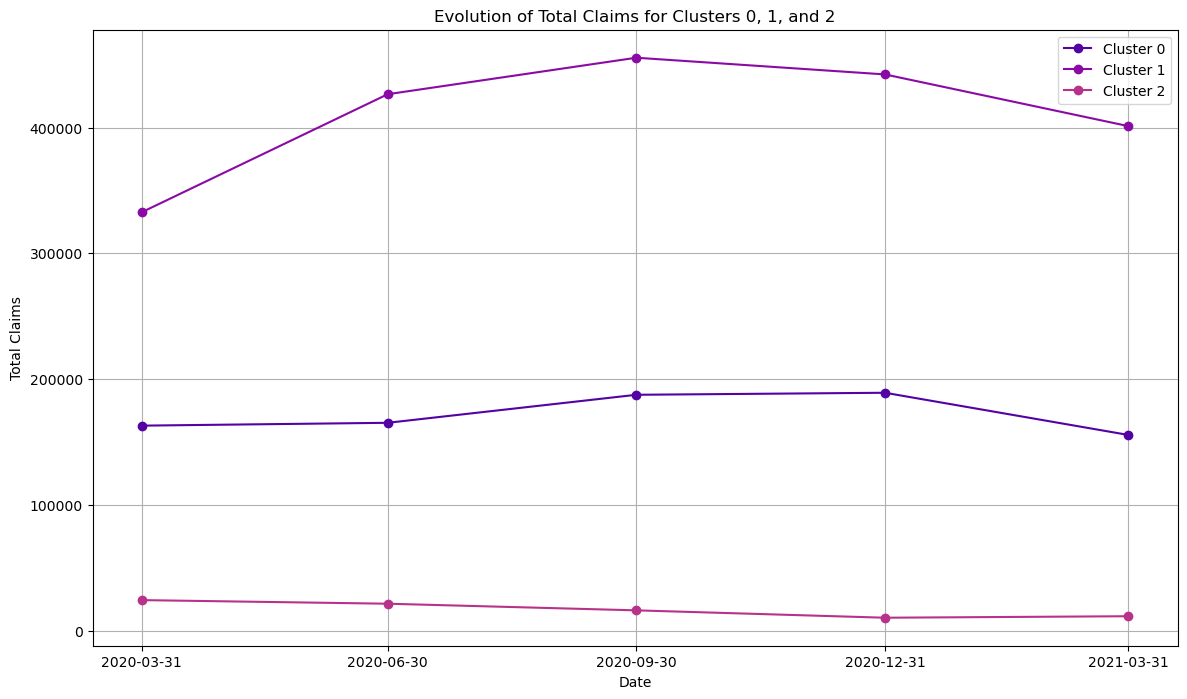

In [282]:
def process_and_plot(dfs, titles, main_title):
    plt.figure(figsize=(14, 8))
    
    # Define x-ticks
    x_ticks = pd.to_datetime(['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31'])
    
    for df, title in zip(dfs, titles):
        # Convert 'date' column to datetime if not already
        df['date'] = pd.to_datetime(df['date'])
        
        # Sum total_claims per date
        df_sum = df.groupby('date')['total_claims'].sum().reset_index()
        
        # Plot the evolution of the sum
        plt.plot(df_sum['date'], df_sum['total_claims'], marker='o', label=title)
    
    plt.title(main_title)
    plt.xlabel('Date')
    plt.ylabel('Total Claims')
    plt.grid(True)
    plt.xticks(x_ticks, x_ticks.strftime('%Y-%m-%d'))
    plt.legend()
    plt.show()

# List of DataFrames and their corresponding titles
dfs = [df_cluster_0_final, df_cluster_1_final, df_cluster_2_final]
titles = ['Cluster 0', 'Cluster 1', 'Cluster 2']
main_title = 'Evolution of Total Claims for Clusters 0, 1, and 2'

process_and_plot(dfs, titles, main_title)

In [285]:
def process_dataframe(df):
    # Convert 'date' column to datetime if not already
    df['date'] = pd.to_datetime(df['date'])

    # Sum total_claims per date
    df_sum = df.groupby('date')['total_claims'].sum()
    return df_sum

# Process each DataFrame
df_sum_0 = process_dataframe(df_cluster_0_final)
df_sum_1 = process_dataframe(df_cluster_1_final)
df_sum_2 = process_dataframe(df_cluster_2_final)

# Combine the results into a single DataFrame
result_df = pd.DataFrame({
    'Cluster 0': df_sum_0,
    'Cluster 1': df_sum_1,
    'Cluster 2': df_sum_2
})

# Transpose the DataFrame to have clusters as rows and dates as columns
result_df = result_df.T

# Fill NaN values with 0 (in case some dates are not present in some clusters)
result_df = result_df.fillna(0)

# Reset index to have a clean table
result_df = result_df.reset_index()

# Rename the index column to 'Cluster'
result_df = result_df.rename(columns={'index': 'Cluster'})

# Format the date columns to only show the date
result_df.columns = ['Cluster'] + [col.strftime('%Y-%m-%d') if isinstance(col, pd.Timestamp) else col for col in result_df.columns[1:]]

# Print the resulting table
result_df


,Cluster,2020-03-31,2020-06-30,2020-09-30,2020-12-31,2021-03-31
0,Cluster 0,163000,165263,187544,189150,155625
1,Cluster 1,332768,426595,455605,442326,401226
2,Cluster 2,24247,21383,16098,10241,11425
